In [179]:
# Celda 1: Importaciones y Configuración de Logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os
from dotenv import load_dotenv # Para cargar variables de entorno
import psycopg2 # Para conectar con PostgreSQL
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.mosaicplot import mosaic
from math import pi



logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(filename)s:%(lineno)d - %(message)s', # Añadido filename y lineno
    handlers=[
        logging.FileHandler('001_mini_eda_predictions.log'),
        logging.StreamHandler()
    ]
)

logging.info("Inicio del notebook de EDA de Predicciones (001_mini_eda_predicciones.ipynb).")

# Configuraciones de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Configuraciones de Matplotlib/Seaborn (opcional, para mejor estética)
plt.style.use('seaborn-v0_8-whitegrid') # O cualquier otro estilo que te guste
sns.set_palette("viridis") # Paleta de colores

2025-05-22 15:43:09,905 - INFO - 2024255416.py:25 - Inicio del notebook de EDA de Predicciones (001_mini_eda_predicciones.ipynb).


In [180]:
# Celda 2: Establecimiento de Variables de Entorno y Conexión a PostgreSQL
logging.info("Cargando variables de entorno para la conexión a PostgreSQL.")

# Asumiendo que tu archivo .env está en ../config/.env relativo a la ubicación del notebook
# Si el notebook está en /data/, entonces ../config/.env sería correcto si config está al mismo nivel que data
notebook_dir = os.getcwd() # O especifica la ruta si es diferente: os.path.dirname(os.path.abspath(__file__)) si fuera un .py
project_root_from_notebook = os.path.dirname(notebook_dir) # Sube un nivel desde 'data' a 'workshop_3'
env_path = os.path.join(project_root_from_notebook, 'config', '.env')

if os.path.exists(env_path):
    load_dotenv(env_path)
    logging.info(f"Variables de entorno cargadas desde: {env_path}")
else:
    logging.warning(f"Archivo .env no encontrado en {env_path}. Se usarán valores por defecto o fallará la conexión.")

# Variables de conexión a PostgreSQL (obtenidas del .env o con valores por defecto)
PG_HOST = os.getenv('POSTGRES_HOST', 'localhost')
PG_PORT = os.getenv('POSTGRES_PORT', '5432')
PG_DATABASE = os.getenv('POSTGRES_DATABASE', 'mrsasayo') # Asegúrate que sea el nombre correcto de tu DB
PG_USER = os.getenv('POSTGRES_USER', 'postgres')
PG_PASSWORD = os.getenv('POSTGRES_PASSWORD', 'postgres')
PG_TABLE_NAME = os.getenv('PG_PREDICTIONS_TABLE', 'happiness_predictions') # Nombre de tu tabla de predicciones

logging.info(f"Configuración de PostgreSQL completada.")

2025-05-22 15:43:09,919 - INFO - 1701110251.py:2 - Cargando variables de entorno para la conexión a PostgreSQL.
2025-05-22 15:43:09,920 - INFO - 1701110251.py:12 - Variables de entorno cargadas desde: /home/nicolas/Escritorio/workshops_ETL/workshop_3/config/.env
2025-05-22 15:43:09,921 - INFO - 1701110251.py:24 - Configuración de PostgreSQL completada.


In [181]:
# Celda 3: Cargar el DataFrame desde PostgreSQL

logging.info(f"Intentando cargar datos desde la tabla '{PG_TABLE_NAME}' de PostgreSQL.")
df_predictions = None # Inicializar DataFrame
conn = None # Inicializar conexión

try:
    conn = psycopg2.connect(
        host=PG_HOST,
        port=PG_PORT,
        database=PG_DATABASE,
        user=PG_USER,
        password=PG_PASSWORD
    )
    logging.info("Conexión a PostgreSQL establecida exitosamente.")
    
    query = f"SELECT * FROM {PG_TABLE_NAME};" # Ajusta el esquema si es necesario, ej. public.{PG_TABLE_NAME}
    
    df_predictions = pd.read_sql_query(query, conn)
    logging.info(f"Datos cargados desde '{PG_TABLE_NAME}'. El DataFrame tiene {df_predictions.shape[0]} filas y {df_predictions.shape[1]} columnas.")
    
    # Verificar columnas clave
    required_cols = ['happiness_score', 'predicted_happiness_score']
    missing_cols = [col for col in required_cols if col not in df_predictions.columns]
    if missing_cols:
        logging.error(f"Columnas requeridas faltantes en el DataFrame cargado: {missing_cols}")
        df_predictions = None # Invalidar DataFrame si faltan columnas críticas
    else:
        # Convertir a numérico si es necesario y manejar errores
        for col in ['happiness_score', 'predicted_happiness_score']:
            df_predictions[col] = pd.to_numeric(df_predictions[col], errors='coerce')
        
        # Eliminar filas donde el score real o predicho sea NaN, ya que no se pueden comparar
        original_rows = len(df_predictions)
        df_predictions.dropna(subset=['happiness_score', 'predicted_happiness_score'], inplace=True)
        if len(df_predictions) < original_rows:
            logging.warning(f"{original_rows - len(df_predictions)} filas eliminadas debido a NaNs en 'happiness_score' o 'predicted_happiness_score'.")

except psycopg2.Error as e:
    logging.error(f"Error de PostgreSQL al conectar o ejecutar query: {e}")
except Exception as e:
    logging.error(f"Error inesperado al cargar datos desde PostgreSQL: {e}")
finally:
    if conn:
        conn.close()
        logging.info("Conexión a PostgreSQL cerrada.")

if df_predictions is not None and not df_predictions.empty:
    logging.info("DataFrame 'df_predictions' cargado y listo para el análisis.")
else:
    logging.error("El DataFrame 'df_predictions' no pudo ser cargado o está vacío después de la limpieza inicial.")

2025-05-22 15:43:09,933 - INFO - 877531839.py:3 - Intentando cargar datos desde la tabla 'happiness_predictions' de PostgreSQL.
DETAIL:  La base de datos fue creada usando la versión de ordenamiento 2.31, pero el sistema operativo provee la versión 2.35.
HINT:  Reconstruya todos los objetos en esta base de datos que usen el ordenamiento por omisión y ejecute ALTER DATABASE mrsasayo REFRESH COLLATION VERSION, o construya PostgreSQL con la versión correcta de la biblioteca.
2025-05-22 15:43:09,940 - INFO - 877531839.py:15 - Conexión a PostgreSQL establecida exitosamente.
/tmp/ipykernel_673587/877531839.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_predictions = pd.read_sql_query(query, conn)
2025-05-22 15:43:09,944 - INFO - 877531839.py:20 - Datos cargados desde 'happiness_predictions'. El DataFrame tiene 157 filas y 14 col

In [182]:
# Celda 4: Verificación Inicial del DataFrame Cargado

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    logging.info("Mostrando información básica y primeras filas del DataFrame 'df_predictions'.")
    
    print("\nPrimeras 5 filas del DataFrame 'df_predictions' (Markdown):")
    print(df_predictions.head(2).to_markdown(index=False))
    
else:
    logging.error("El DataFrame 'df_predictions' no está cargado o está vacío. Por favor, revisa la celda de carga.")

2025-05-22 15:43:09,954 - INFO - 3634363900.py:4 - Mostrando información básica y primeras filas del DataFrame 'df_predictions'.



Primeras 5 filas del DataFrame 'df_predictions' (Markdown):
|   id |   year | region             | country   |   happiness_rank |   happiness_score |   social_support |   health_life_expectancy |   generosity |   freedom_to_make_life_choices |   economy_gdp_per_capita |   perceptions_of_corruption |   predicted_happiness_score | prediction_timestamp       |
|-----:|-------:|:-------------------|:----------|-----------------:|------------------:|-----------------:|-------------------------:|-------------:|-------------------------------:|-------------------------:|----------------------------:|----------------------------:|:---------------------------|
|    1 |   2018 | Sub-Saharan Africa | Ethiopia  |              127 |             4.35  |            0.95  |                    0.391 |        0.22  |                          0.452 |                    0.308 |                       0.146 |                     4.30681 | 2025-05-22 14:23:37.064953 |
|    2 |   2018 | Sub-Saharan Africa | 

2025-05-22 15:43:09,963 - INFO - 1986550828.py:4 - Generando gráfica de dispersión: Real vs. Predicho.


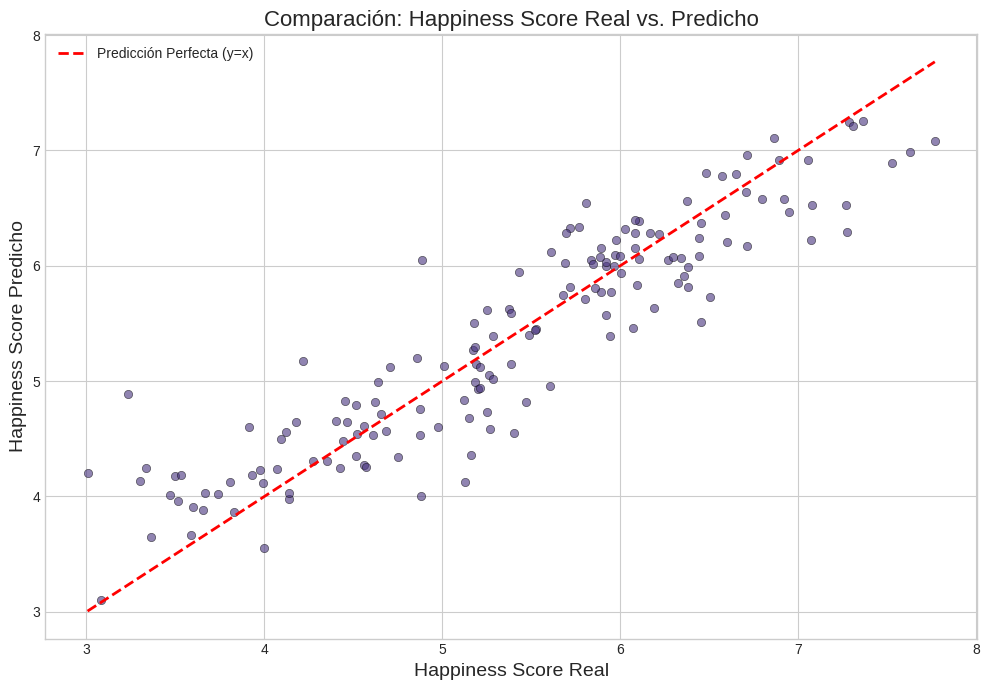

2025-05-22 15:43:10,080 - INFO - 1986550828.py:21 - Gráfica de dispersión Real vs. Predicho mostrada.


In [183]:
# Celda 5: Gráfica de Dispersión: Real vs. Predicho

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    logging.info("Generando gráfica de dispersión: Real vs. Predicho.")
    plt.figure(figsize=(10, 7))
    
    sns.scatterplot(x='happiness_score', y='predicted_happiness_score', data=df_predictions, alpha=0.6, edgecolor='k')
    
    # Línea y=x para referencia de predicción perfecta
    min_val = min(df_predictions['happiness_score'].min(), df_predictions['predicted_happiness_score'].min())
    max_val = max(df_predictions['happiness_score'].max(), df_predictions['predicted_happiness_score'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Predicción Perfecta (y=x)')
    
    plt.title('Comparación: Happiness Score Real vs. Predicho', fontsize=16)
    plt.xlabel('Happiness Score Real', fontsize=14)
    plt.ylabel('Happiness Score Predicho', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    logging.info("Gráfica de dispersión Real vs. Predicho mostrada.")
else:
    logging.warning("df_predictions no disponible para graficar Real vs. Predicho.")

2025-05-22 15:43:10,090 - INFO - 2458899772.py:7 - Calculando la columna 'residuals' (Real - Predicho) para la gráfica de Residuos vs. Reales.
2025-05-22 15:43:10,091 - INFO - 2458899772.py:13 - Generando gráfica de dispersión: Residuos vs. Valores Reales.


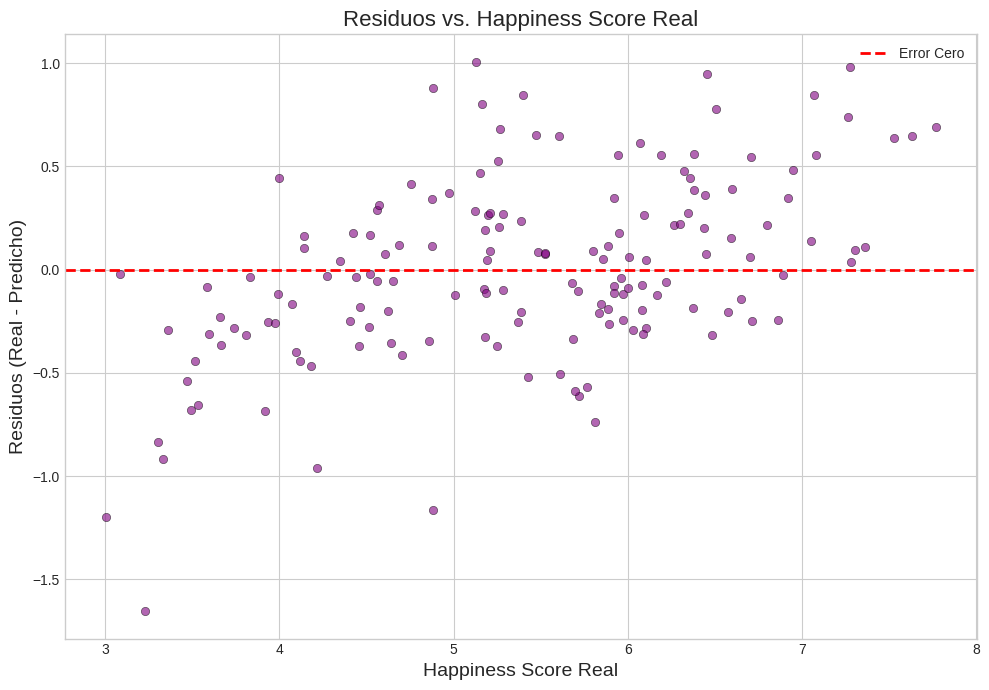

2025-05-22 15:43:10,209 - INFO - 2458899772.py:28 - Gráfica de dispersión Residuos vs. Reales mostrada.


In [184]:
# Celda 10: Gráfica de Dispersión de Residuos vs. Valores Reales

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    # Asegurar que la columna 'residuals' exista (similar a la Celda 6)
    if 'happiness_score' in df_predictions.columns and 'predicted_happiness_score' in df_predictions.columns:
        if 'residuals' not in df_predictions.columns:
            logging.info("Calculando la columna 'residuals' (Real - Predicho) para la gráfica de Residuos vs. Reales.")
            df_predictions['residuals'] = df_predictions['happiness_score'] - df_predictions['predicted_happiness_score']
    else:
        logging.error("No se pueden calcular los residuos: 'happiness_score' o 'predicted_happiness_score' faltan en df_predictions.")

    if 'residuals' in df_predictions.columns and 'happiness_score' in df_predictions.columns:
        logging.info("Generando gráfica de dispersión: Residuos vs. Valores Reales.")
        plt.figure(figsize=(10, 7))
        
        sns.scatterplot(x='happiness_score', y='residuals', data=df_predictions, alpha=0.6, edgecolor='k', color='purple')
        
        # Línea y=0 para referencia de error cero
        plt.axhline(0, color='red', linestyle='--', lw=2, label='Error Cero')
        
        plt.title('Residuos vs. Happiness Score Real', fontsize=16)
        plt.xlabel('Happiness Score Real', fontsize=14)
        plt.ylabel('Residuos (Real - Predicho)', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        logging.info("Gráfica de dispersión Residuos vs. Reales mostrada.")
    else:
        logging.warning("df_predictions o columnas 'residuals'/'happiness_score' no disponibles para graficar Residuos vs. Reales.")
else:
    logging.warning("df_predictions no está cargado o está vacío. No se puede graficar Residuos vs. Reales.")

2025-05-22 15:43:10,218 - INFO - 2084652249.py:18 - Generando gráfica de dispersión: Residuos vs. Valores Predichos.


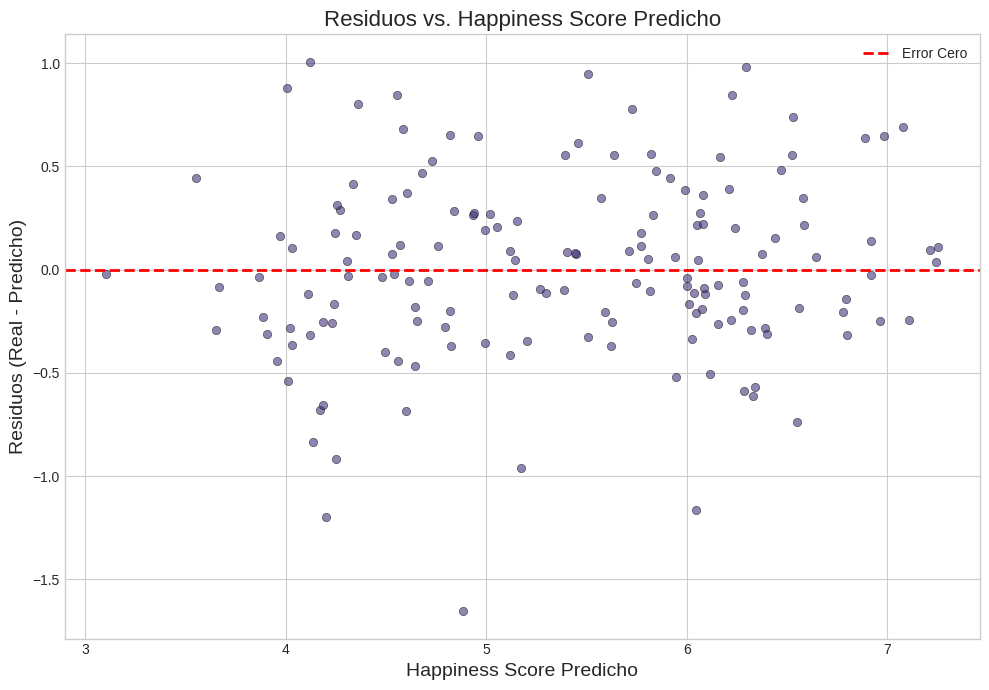

2025-05-22 15:43:10,346 - INFO - 2084652249.py:33 - Gráfica de dispersión Residuos vs. Predicho mostrada.


In [185]:
# Celda 6: Gráfica de Dispersión de Residuos vs. Valores Predichos

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    # --- Asegurar que la columna 'residuals' exista ---
    if 'happiness_score' in df_predictions.columns and 'predicted_happiness_score' in df_predictions.columns:
        if 'residuals' not in df_predictions.columns:
            logging.info("Calculando la columna 'residuals' (Real - Predicho).")
            df_predictions['residuals'] = df_predictions['happiness_score'] - df_predictions['predicted_happiness_score']
        # else: # Opcional: si quieres recalcularla siempre
            # logging.info("Recalculando la columna 'residuals' (Real - Predicho).")
            # df_predictions['residuals'] = df_predictions['happiness_score'] - df_predictions['predicted_happiness_score']
    else:
        logging.error("No se pueden calcular los residuos: 'happiness_score' o 'predicted_happiness_score' faltan en df_predictions.")
        # Aquí podrías decidir no continuar con la gráfica si las columnas base no existen.
    # --- Fin de la creación/verificación de 'residuals' ---

    if 'residuals' in df_predictions.columns: # Verificar de nuevo después del intento de cálculo
        logging.info("Generando gráfica de dispersión: Residuos vs. Valores Predichos.")
        plt.figure(figsize=(10, 7))
        
        sns.scatterplot(x='predicted_happiness_score', y='residuals', data=df_predictions, alpha=0.6, edgecolor='k')
        
        # Línea y=0 para referencia de error cero
        plt.axhline(0, color='red', linestyle='--', lw=2, label='Error Cero')
        
        plt.title('Residuos vs. Happiness Score Predicho', fontsize=16)
        plt.xlabel('Happiness Score Predicho', fontsize=14)
        plt.ylabel('Residuos (Real - Predicho)', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        logging.info("Gráfica de dispersión Residuos vs. Predicho mostrada.")
    else:
        logging.warning("df_predictions o columna 'residuals' no disponible para graficar Residuos vs. Predicho (incluso después del intento de cálculo).")
else:
    logging.warning("df_predictions no está cargado o está vacío. No se puede graficar Residuos vs. Predicho.")

2025-05-22 15:43:10,353 - INFO - 3042634338.py:4 - Generando histograma de Residuos.


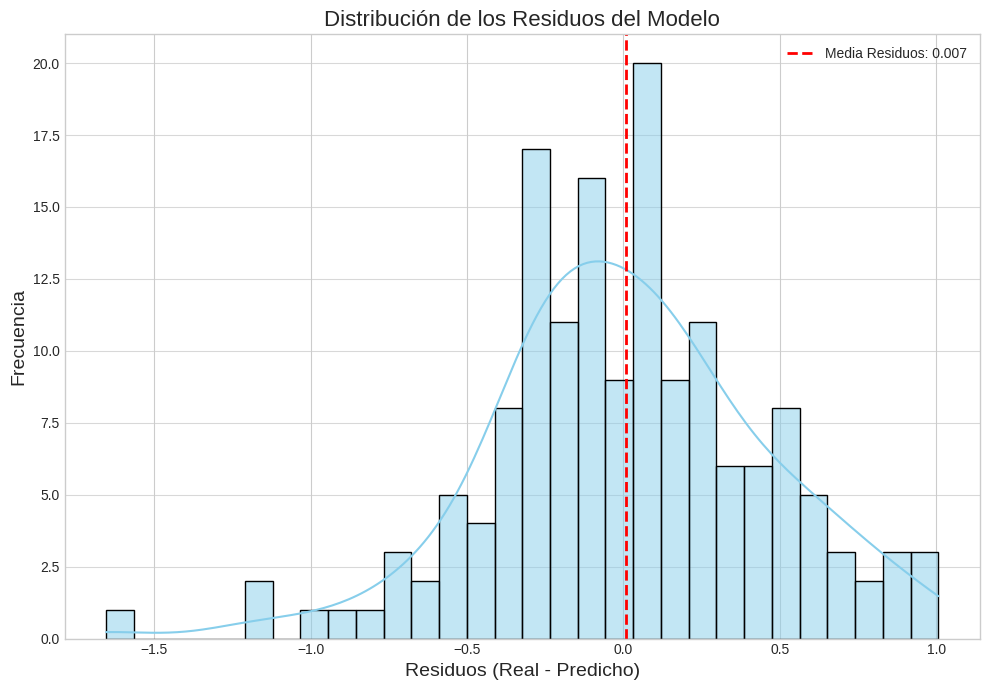

2025-05-22 15:43:10,533 - INFO - 3042634338.py:18 - Histograma de Residuos mostrado.


In [186]:
# Celda 7: Histograma de Residuos

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'residuals' in df_predictions.columns:
    logging.info("Generando histograma de Residuos.")
    plt.figure(figsize=(10, 7))
    
    sns.histplot(df_predictions['residuals'], kde=True, bins=30, color='skyblue', edgecolor='black')
    
    plt.axvline(df_predictions['residuals'].mean(), color='red', linestyle='--', lw=2, label=f'Media Residuos: {df_predictions["residuals"].mean():.3f}')
    
    plt.title('Distribución de los Residuos del Modelo', fontsize=16)
    plt.xlabel('Residuos (Real - Predicho)', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()
    logging.info("Histograma de Residuos mostrado.")
else:
    logging.warning("df_predictions o columna 'residuals' no disponible para graficar Histograma de Residuos.")

2025-05-22 15:43:10,540 - INFO - 712322237.py:4 - Generando histogramas superpuestos: Real vs. Predicho.


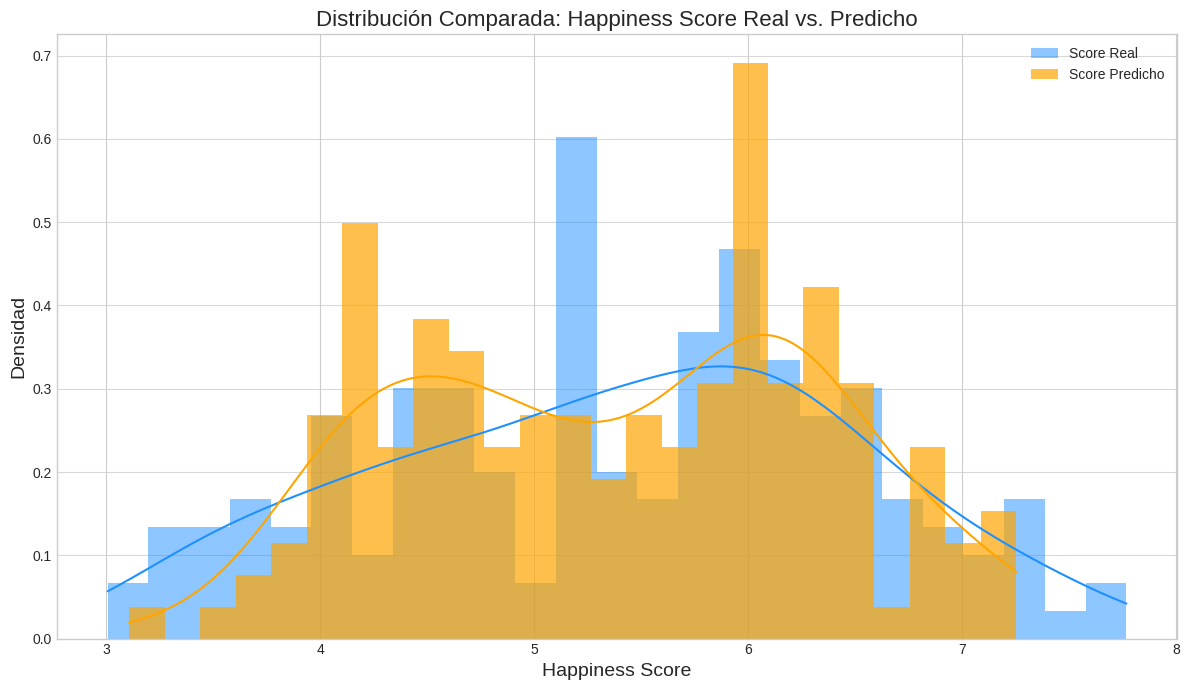

2025-05-22 15:43:10,770 - INFO - 712322237.py:17 - Histogramas superpuestos mostrados.


In [187]:
# Celda 8: Histogramas Superpuestos: Distribución de Valores Reales vs. Predichos

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    logging.info("Generando histogramas superpuestos: Real vs. Predicho.")
    plt.figure(figsize=(12, 7))
    
    sns.histplot(df_predictions['happiness_score'], color="dodgerblue", label='Score Real', kde=True, stat="density", linewidth=0, bins=25)
    sns.histplot(df_predictions['predicted_happiness_score'], color="orange", label='Score Predicho', kde=True, stat="density", linewidth=0, bins=25, alpha=0.7)
    
    plt.title('Distribución Comparada: Happiness Score Real vs. Predicho', fontsize=16)
    plt.xlabel('Happiness Score', fontsize=14)
    plt.ylabel('Densidad', fontsize=14)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()
    logging.info("Histogramas superpuestos mostrados.")
else:
    logging.warning("df_predictions no disponible para graficar histogramas superpuestos.")

2025-05-22 15:43:10,778 - INFO - 2909971039.py:4 - Generando Box Plot de Residuos por Región.
/tmp/ipykernel_673587/2909971039.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='residuals', data=df_predictions, # order=region_order,


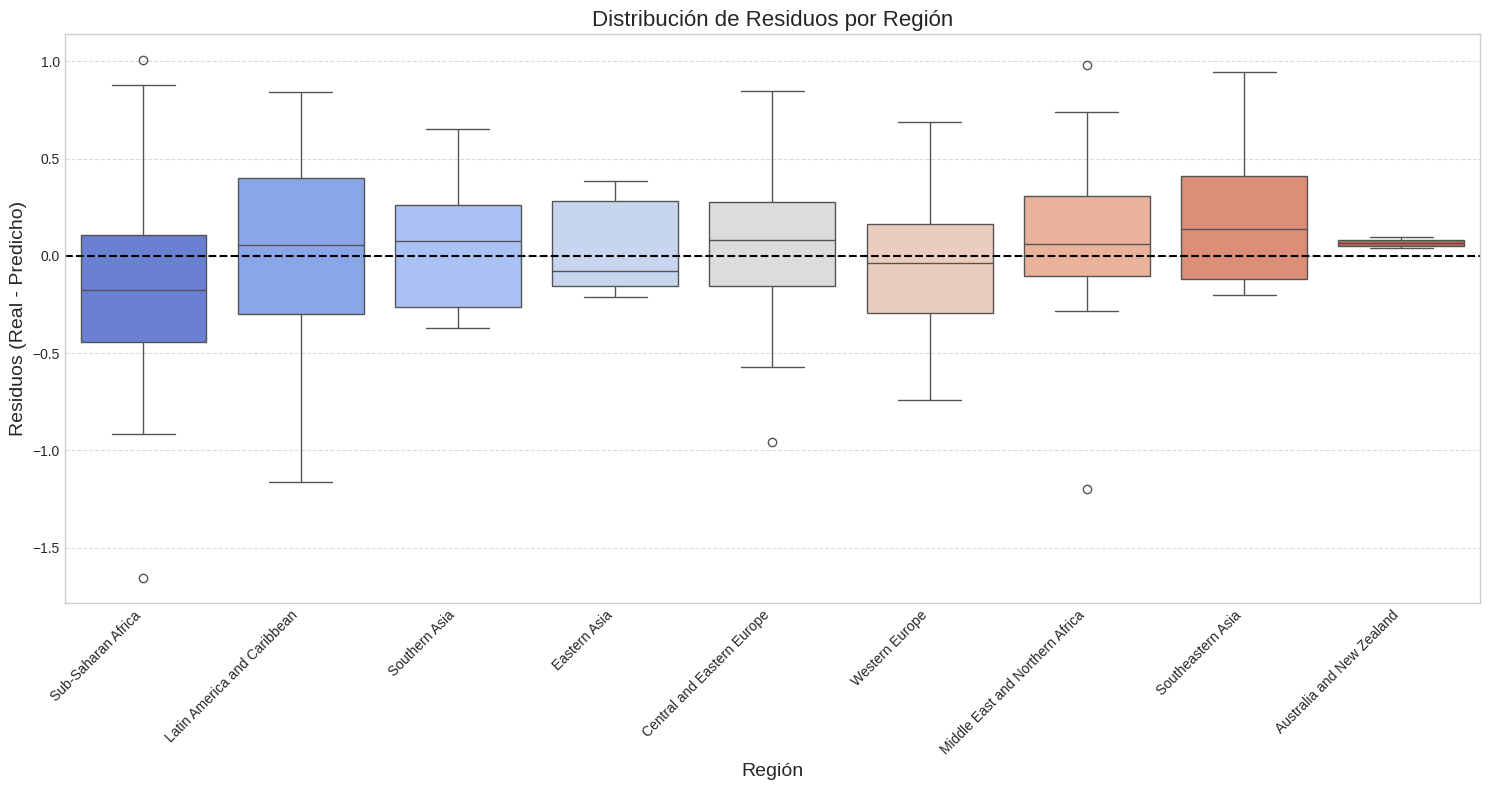

2025-05-22 15:43:10,956 - INFO - 2909971039.py:22 - Box Plot de Residuos por Región mostrado.


In [188]:
# Celda 9: Box Plot de Residuos por Región

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'region' in df_predictions.columns and 'residuals' in df_predictions.columns:
    logging.info("Generando Box Plot de Residuos por Región.")
    
    # Ordenar regiones por la mediana de sus residuos para mejor visualización (opcional)
    # region_order = df_predictions.groupby('region')['residuals'].median().sort_values().index
    
    plt.figure(figsize=(15, 8)) # Ajustar tamaño según número de regiones
    
    sns.boxplot(x='region', y='residuals', data=df_predictions, # order=region_order,
                palette="coolwarm") # Usar una paleta divergente para residuos
    
    plt.axhline(0, color='black', linestyle='--', lw=1.5)
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotar etiquetas del eje X si son muchas
    plt.title('Distribución de Residuos por Región', fontsize=16)
    plt.xlabel('Región', fontsize=14)
    plt.ylabel('Residuos (Real - Predicho)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logging.info("Box Plot de Residuos por Región mostrado.")
else:
    logging.warning("df_predictions o columnas 'region'/'residuals' no disponibles para Box Plot por Región.")

2025-05-22 15:43:10,966 - INFO - 286845567.py:4 - Generando Box Plots comparativos: Real vs. Predicho por Región.


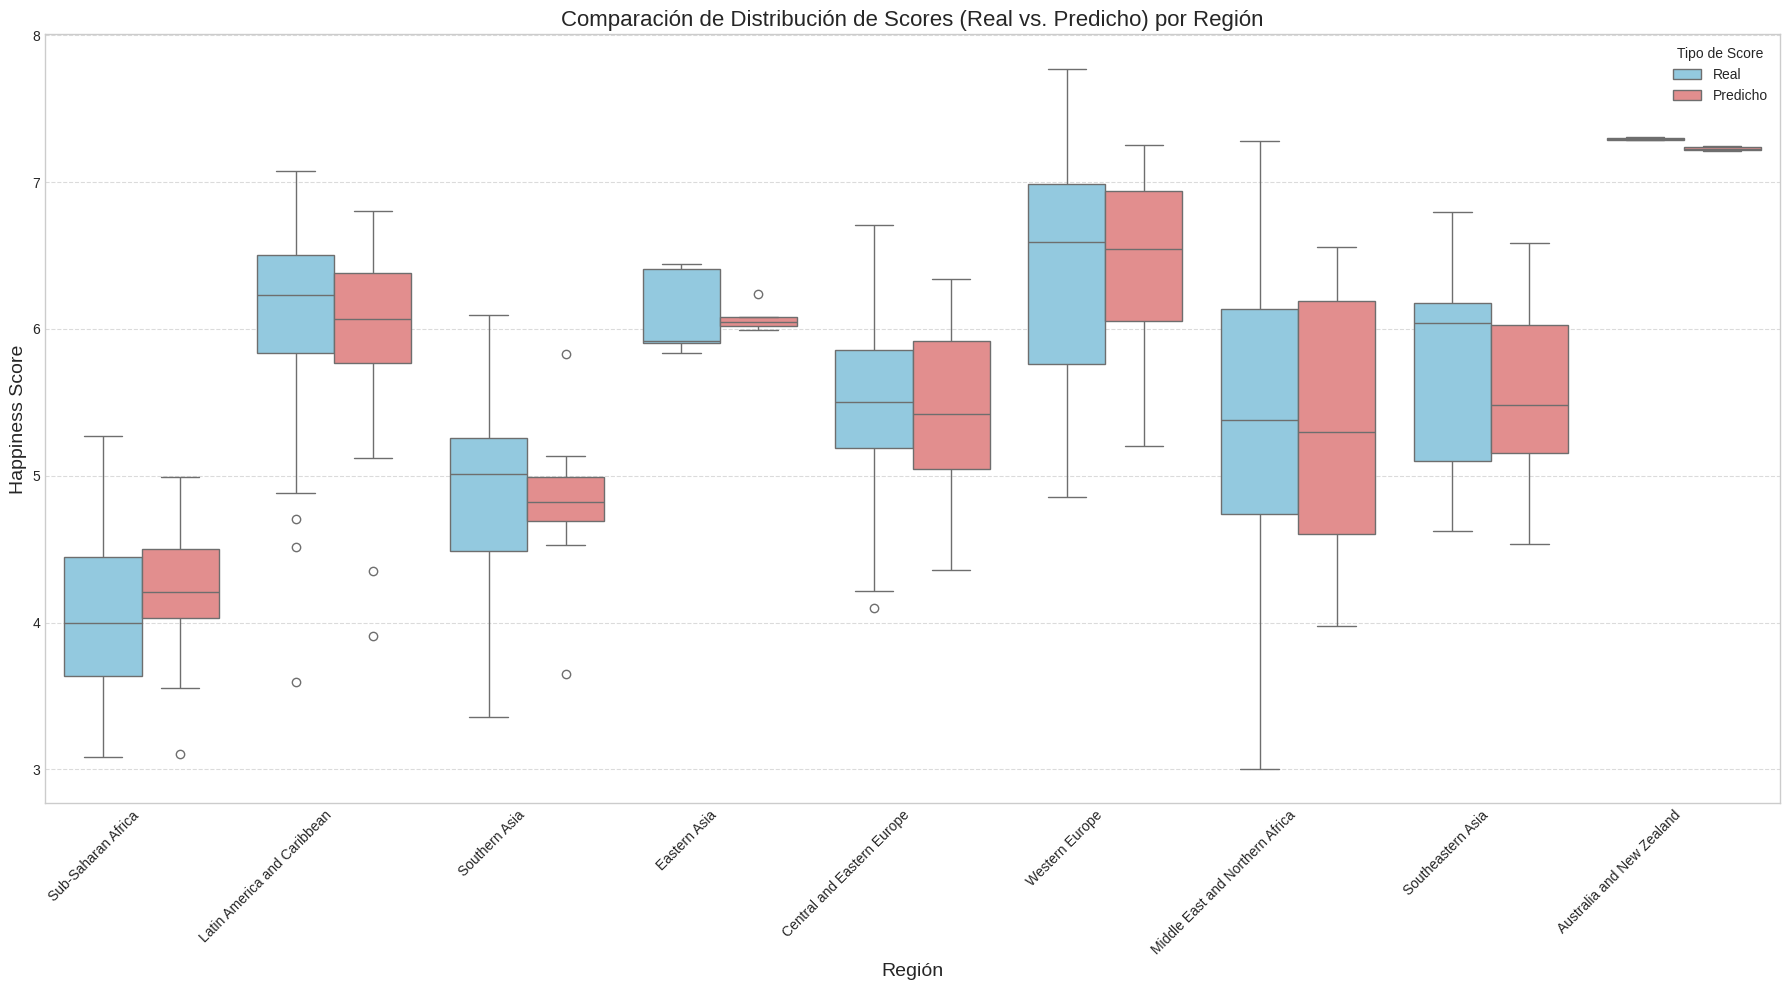

2025-05-22 15:43:11,286 - INFO - 286845567.py:34 - Box Plots comparativos por Región mostrados.


In [189]:
# Celda 11: Box Plots Comparativos: Happiness Score Real vs. Predicho por Región

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'region' in df_predictions.columns:
    logging.info("Generando Box Plots comparativos: Real vs. Predicho por Región.")

    # Preparamos los datos para el boxplot: necesitamos una columna para el tipo de score (Real/Predicho)
    # y otra para el valor del score.
    df_real_scores = df_predictions[['region', 'happiness_score']].copy()
    df_real_scores['score_type'] = 'Real'
    df_real_scores.rename(columns={'happiness_score': 'score_value'}, inplace=True)

    df_pred_scores = df_predictions[['region', 'predicted_happiness_score']].copy()
    df_pred_scores['score_type'] = 'Predicho'
    df_pred_scores.rename(columns={'predicted_happiness_score': 'score_value'}, inplace=True)

    df_plot_boxplot = pd.concat([df_real_scores, df_pred_scores], ignore_index=True)

    # Ordenar regiones por la mediana del score real para mejor visualización (opcional)
    # region_order_boxplot = df_predictions.groupby('region')['happiness_score'].median().sort_values(ascending=False).index

    plt.figure(figsize=(18, 10)) # Ajustar tamaño según número de regiones
    
    sns.boxplot(x='region', y='score_value', hue='score_type', data=df_plot_boxplot, # order=region_order_boxplot,
                palette={"Real": "skyblue", "Predicho": "lightcoral"})
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title('Comparación de Distribución de Scores (Real vs. Predicho) por Región', fontsize=16)
    plt.xlabel('Región', fontsize=14)
    plt.ylabel('Happiness Score', fontsize=14)
    plt.legend(title='Tipo de Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logging.info("Box Plots comparativos por Región mostrados.")
else:
    logging.warning("df_predictions o columna 'region' no disponible para Box Plots comparativos por Región.")

In [190]:
# Celda 12: Cálculo de Métricas de Error del Modelo

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'residuals' in df_predictions.columns:
    logging.info("Calculando métricas de error del modelo.")
    
    y_true = df_predictions['happiness_score']
    y_pred = df_predictions['predicted_happiness_score']
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    mean_residuals = df_predictions['residuals'].mean()
    std_residuals = df_predictions['residuals'].std()
    
    print("\n--- Métricas de Error del Modelo ---")
    print(f"Mean Absolute Error (MAE):     {mae:.4f}")
    print(f"Mean Squared Error (MSE):      {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE):{rmse:.4f}")
    print(f"R-squared (R²):                {r2:.4f}")
    print(f"Media de los Residuos:         {mean_residuals:.4f}")
    print(f"Desv. Estándar de Residuos:    {std_residuals:.4f}")
    logging.info(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Mean Residuals: {mean_residuals:.4f}")

    # Opcional: Podrías crear un bar plot simple para MAE/RMSE si los calculas por categoría
    # Ejemplo (si calculas MAE por región):
    # if 'region' in df_predictions.columns:
    #     mae_by_region = df_predictions.groupby('region').apply(lambda x: mean_absolute_error(x['happiness_score'], x['predicted_happiness_score']))
    #     mae_by_region = mae_by_region.sort_values()
    #     plt.figure(figsize=(12, 6))
    #     mae_by_region.plot(kind='bar', color='teal')
    #     plt.title('Mean Absolute Error (MAE) por Región')
    #     plt.ylabel('MAE')
    #     plt.xlabel('Región')
    #     plt.xticks(rotation=45, ha='right')
    #     plt.tight_layout()
    #     plt.show()
else:
    logging.warning("df_predictions o columnas necesarias no disponibles para calcular métricas de error.")

2025-05-22 15:43:11,295 - INFO - 4283789932.py:6 - Calculando métricas de error del modelo.
2025-05-22 15:43:11,300 - INFO - 4283789932.py:26 - MAE: 0.3405, MSE: 0.1945, RMSE: 0.4410, R2: 0.8401, Mean Residuals: 0.0067



--- Métricas de Error del Modelo ---
Mean Absolute Error (MAE):     0.3405
Mean Squared Error (MSE):      0.1945
Root Mean Squared Error (RMSE):0.4410
R-squared (R²):                0.8401
Media de los Residuos:         0.0067
Desv. Estándar de Residuos:    0.4424


2025-05-22 15:43:11,312 - INFO - 3915303802.py:5 - Generando Gráfico de Barras: MAE por Región.
/tmp/ipykernel_673587/3915303802.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_region = df_predictions.groupby('region').apply(


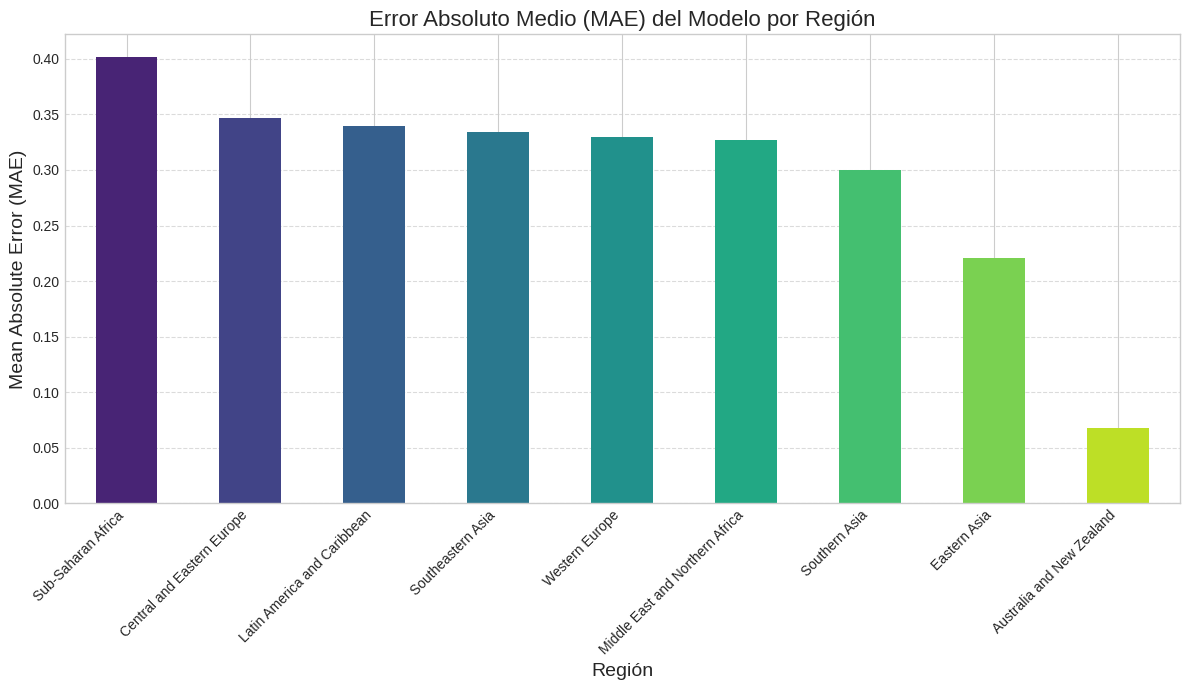

2025-05-22 15:43:11,456 - INFO - 3915303802.py:22 - Gráfico de Barras MAE por Región mostrado.


In [191]:
# Celda 13: Gráfico de Barras - Error Absoluto Medio (MAE) por Región
from sklearn.metrics import mean_absolute_error

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'region' in df_predictions.columns:
    logging.info("Generando Gráfico de Barras: MAE por Región.")
    
    # Calcular MAE por región
    mae_by_region = df_predictions.groupby('region').apply(
        lambda x: mean_absolute_error(x['happiness_score'], x['predicted_happiness_score'])
    ).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 7))
    mae_by_region.plot(kind='bar', color=sns.color_palette("viridis", len(mae_by_region)))
    
    plt.title('Error Absoluto Medio (MAE) del Modelo por Región', fontsize=16)
    plt.xlabel('Región', fontsize=14)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logging.info("Gráfico de Barras MAE por Región mostrado.")
else:
    logging.warning("df_predictions o columna 'region' no disponible para Gráfico de Barras MAE por Región.")

2025-05-22 15:43:11,469 - INFO - 3151826843.py:4 - Generando Gráfico Lineal: Score Promedio Real vs. Predicho por Año.


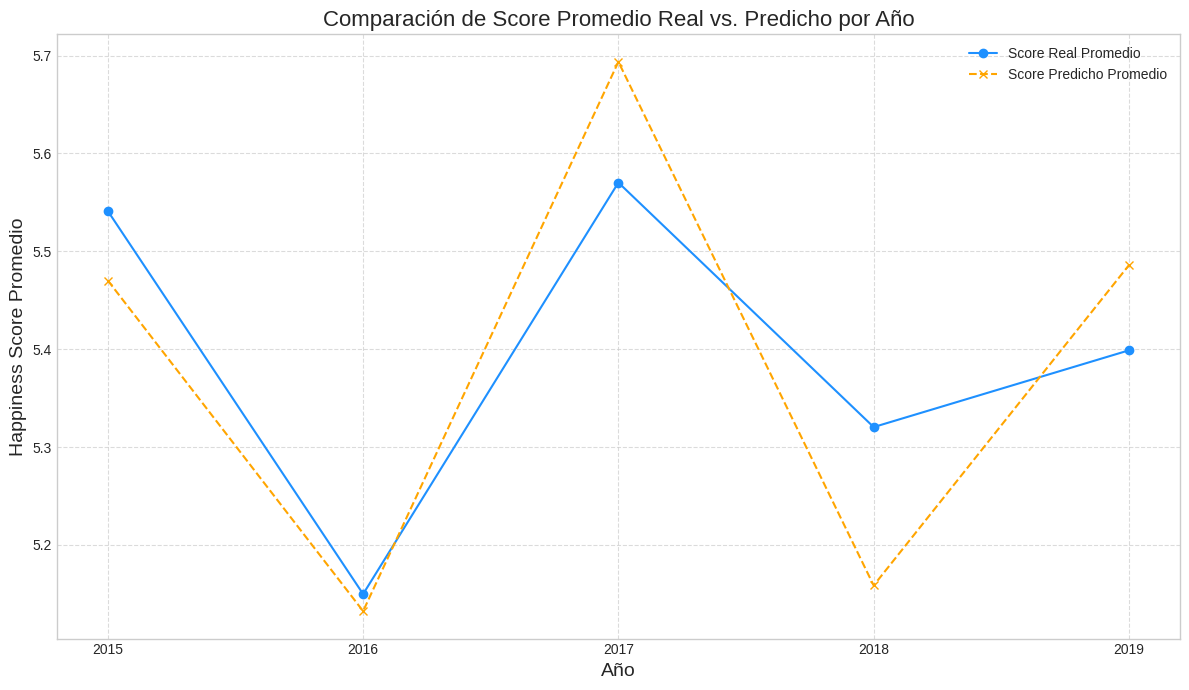

2025-05-22 15:43:11,724 - INFO - 3151826843.py:23 - Gráfico Lineal por Año mostrado.


In [192]:
# Celda 14: Gráfico Lineal - Score Promedio Real vs. Predicho por Año

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'year' in df_predictions.columns:
    logging.info("Generando Gráfico Lineal: Score Promedio Real vs. Predicho por Año.")
    
    avg_scores_by_year = df_predictions.groupby('year').agg(
        avg_real_score=('happiness_score', 'mean'),
        avg_predicted_score=('predicted_happiness_score', 'mean')
    ).reset_index()
    
    plt.figure(figsize=(12, 7))
    plt.plot(avg_scores_by_year['year'], avg_scores_by_year['avg_real_score'], marker='o', linestyle='-', color='dodgerblue', label='Score Real Promedio')
    plt.plot(avg_scores_by_year['year'], avg_scores_by_year['avg_predicted_score'], marker='x', linestyle='--', color='orange', label='Score Predicho Promedio')
    
    plt.title('Comparación de Score Promedio Real vs. Predicho por Año', fontsize=16)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Happiness Score Promedio', fontsize=14)
    plt.xticks(avg_scores_by_year['year'].unique()) # Asegurar que todos los años se muestren
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logging.info("Gráfico Lineal por Año mostrado.")
else:
    logging.warning("df_predictions o columna 'year' no disponible para Gráfico Lineal por Año.")

2025-05-22 15:43:11,731 - INFO - 2558708940.py:4 - Generando Gráfico Circular: Distribución por Rango de Error Absoluto.


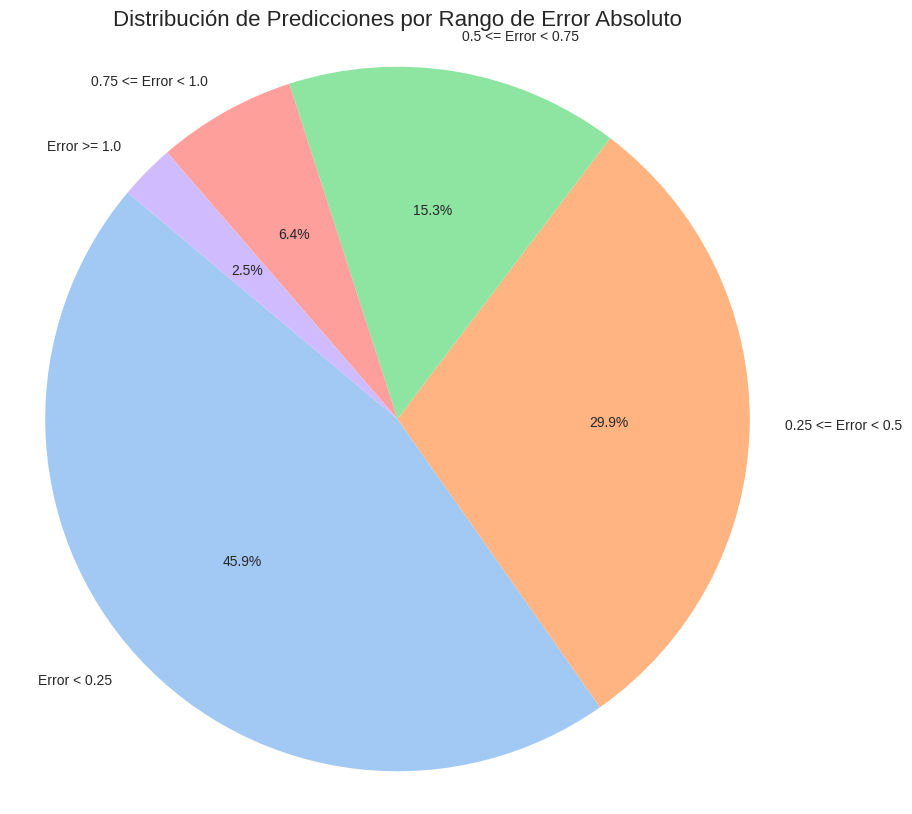

2025-05-22 15:43:11,796 - INFO - 2558708940.py:21 - Gráfico Circular por Rango de Error Absoluto mostrado.


In [193]:
# Celda 15: Gráfico Circular - Distribución por Rango de Error Absoluto

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'residuals' in df_predictions.columns:
    logging.info("Generando Gráfico Circular: Distribución por Rango de Error Absoluto.")
    
    df_predictions['abs_error'] = df_predictions['residuals'].abs()
    
    # Definir rangos de error
    bins = [0, 0.25, 0.5, 0.75, 1.0, df_predictions['abs_error'].max() + 0.1]
    labels = ['Error < 0.25', '0.25 <= Error < 0.5', '0.5 <= Error < 0.75', '0.75 <= Error < 1.0', 'Error >= 1.0']
    df_predictions['error_range'] = pd.cut(df_predictions['abs_error'], bins=bins, labels=labels, right=False)
    
    error_distribution = df_predictions['error_range'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 10))
    plt.pie(error_distribution, labels=error_distribution.index, autopct='%1.1f%%', startangle=140,
            colors=sns.color_palette("pastel", len(error_distribution)))
    plt.title('Distribución de Predicciones por Rango de Error Absoluto', fontsize=16)
    plt.axis('equal') # Asegura que el pie sea un círculo.
    plt.show()
    logging.info("Gráfico Circular por Rango de Error Absoluto mostrado.")
else:
    logging.warning("df_predictions o columna 'residuals' no disponible para Gráfico Circular.")

2025-05-22 15:43:11,804 - INFO - 599537617.py:4 - Generando Mapa de Calor: Correlación de Residuos con Features Numéricas.


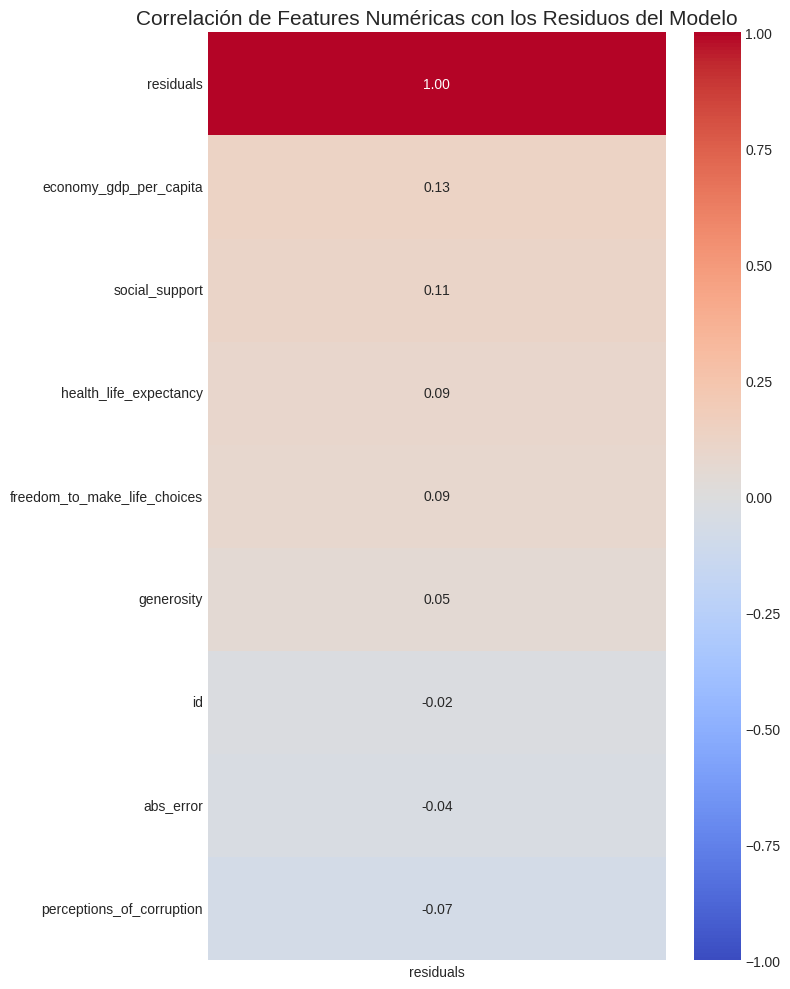

2025-05-22 15:43:11,948 - INFO - 599537617.py:21 - Mapa de Calor de Correlación de Residuos mostrado.


In [194]:
# Celda 16: Mapa de Calor - Correlación de Residuos con Features Numéricas

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'residuals' in df_predictions.columns:
    logging.info("Generando Mapa de Calor: Correlación de Residuos con Features Numéricas.")
    
    numeric_features_for_corr = df_predictions.select_dtypes(include=np.number).columns.tolist()
    # Excluir scores y el propio residuo para la correlación con features
    features_to_correlate = [col for col in numeric_features_for_corr if col not in ['happiness_score', 'predicted_happiness_score', 'residuals', 'happiness_rank', 'year']] 
                                                                            # 'year' y 'rank' pueden no ser tan informativas aquí
    
    if features_to_correlate:
        correlation_data = df_predictions[features_to_correlate + ['residuals']].corr()
        residuals_correlation = correlation_data[['residuals']].sort_values(by='residuals', ascending=False)
        
        plt.figure(figsize=(8, 10))
        sns.heatmap(residuals_correlation, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, cbar=True)
        plt.title('Correlación de Features Numéricas con los Residuos del Modelo', fontsize=15)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        logging.info("Mapa de Calor de Correlación de Residuos mostrado.")
    else:
        logging.warning("No hay suficientes features numéricas (además de scores/residuos) para el mapa de calor de correlación.")
else:
    logging.warning("df_predictions o columna 'residuals' no disponible para Mapa de Calor.")

2025-05-22 15:43:11,955 - INFO - 1711731176.py:4 - Generando Gráfico de Barras Agrupadas: Score Promedio Real vs. Predicho por Región.


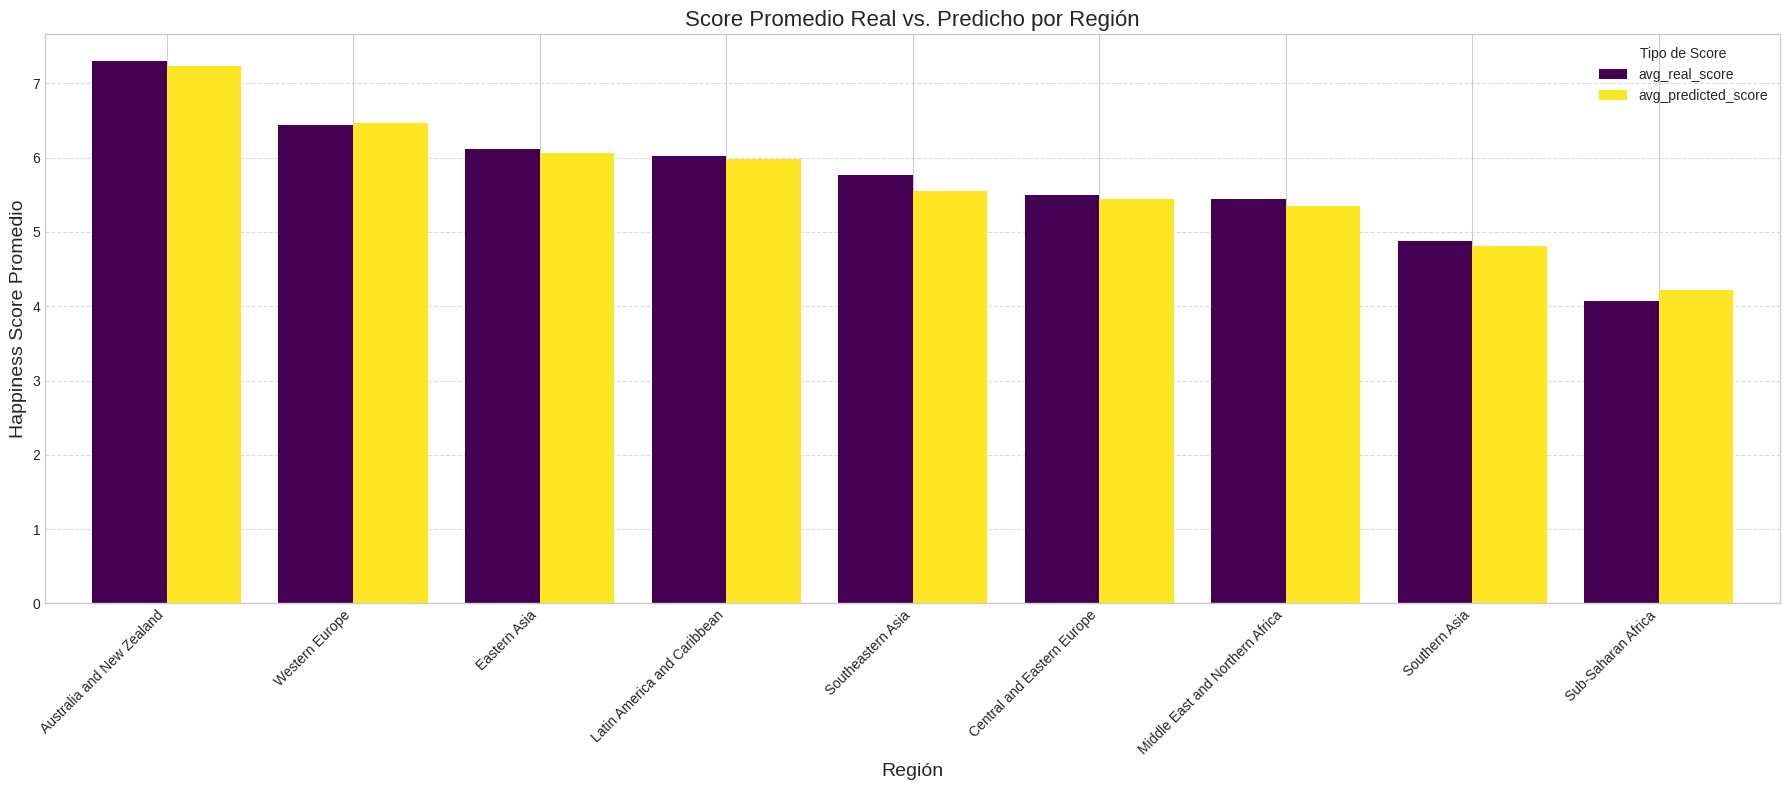

2025-05-22 15:43:12,107 - INFO - 1711731176.py:21 - Gráfico de Barras Agrupadas por Región mostrado.


In [195]:
# Celda 17: Gráfico de Barras Agrupadas - Score Promedio Real vs. Predicho por Región

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'region' in df_predictions.columns:
    logging.info("Generando Gráfico de Barras Agrupadas: Score Promedio Real vs. Predicho por Región.")
    
    avg_scores_by_region = df_predictions.groupby('region').agg(
        avg_real_score=('happiness_score', 'mean'),
        avg_predicted_score=('predicted_happiness_score', 'mean')
    ).sort_values(by='avg_real_score', ascending=False) # Ordenar por score real
    
    avg_scores_by_region.plot(kind='bar', figsize=(18, 8), colormap='viridis', width=0.8)
    
    plt.title('Score Promedio Real vs. Predicho por Región', fontsize=16)
    plt.xlabel('Región', fontsize=14)
    plt.ylabel('Happiness Score Promedio', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Tipo de Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    logging.info("Gráfico de Barras Agrupadas por Región mostrado.")
else:
    logging.warning("df_predictions o columna 'region' no disponible para Gráfico de Barras Agrupadas por Región.")

2025-05-22 15:43:12,115 - INFO - 3220879403.py:5 - Generando Diagrama de Pareto: Contribución al Error Absoluto Total por Región.


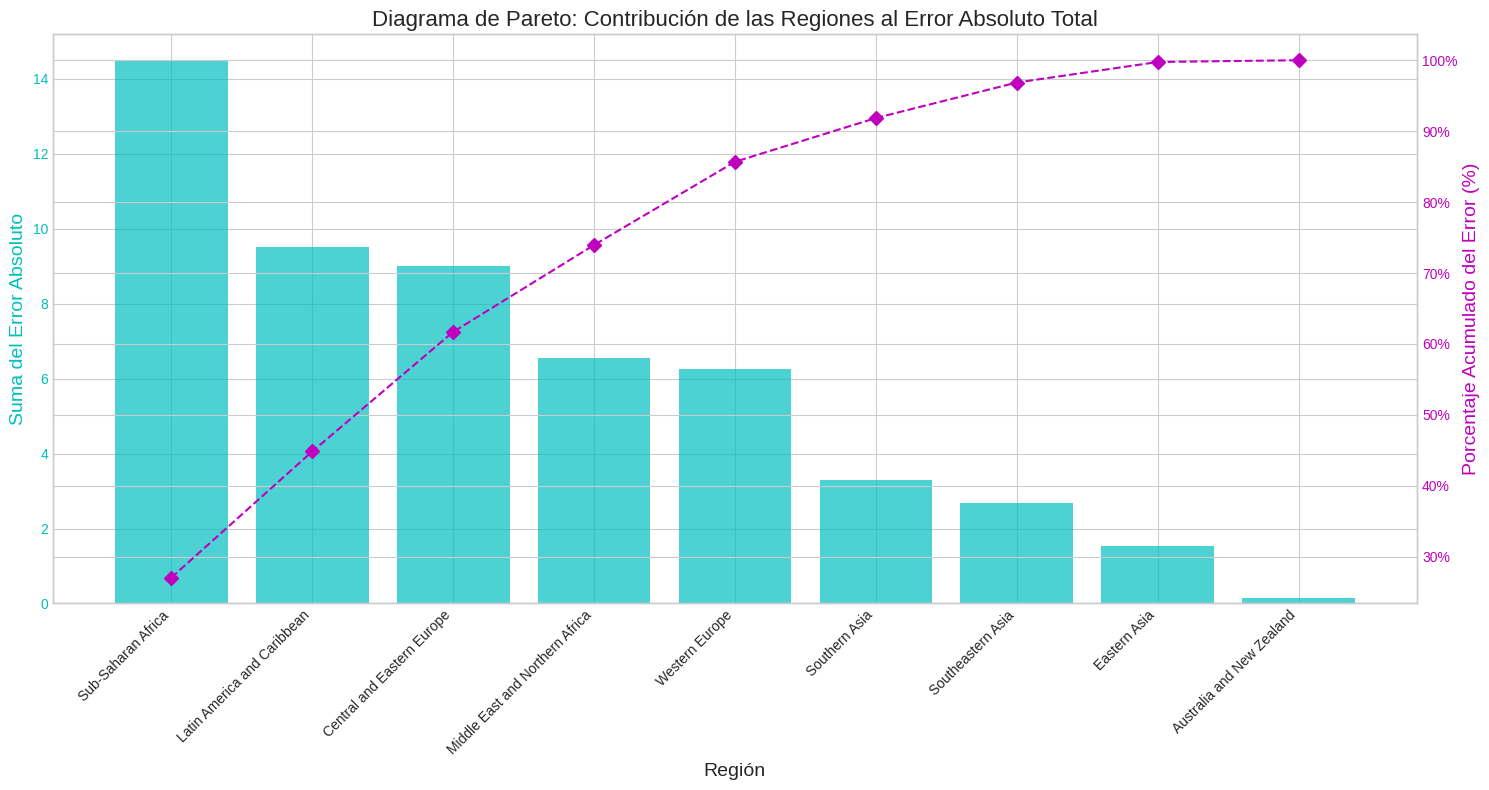

2025-05-22 15:43:12,301 - INFO - 3220879403.py:30 - Diagrama de Pareto mostrado.


In [196]:
# Celda 18: Diagrama de Pareto - Contribución al Error Absoluto Total por Región
from matplotlib.ticker import PercentFormatter

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty and 'region' in df_predictions.columns and 'abs_error' in df_predictions.columns:
    logging.info("Generando Diagrama de Pareto: Contribución al Error Absoluto Total por Región.")

    error_by_region = df_predictions.groupby('region')['abs_error'].sum().sort_values(ascending=False)
    df_pareto = pd.DataFrame({'error_sum': error_by_region})
    df_pareto['cumulative_percentage'] = (df_pareto['error_sum'].cumsum() / df_pareto['error_sum'].sum()) * 100

    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Gráfico de barras para la suma del error
    ax1.bar(df_pareto.index, df_pareto['error_sum'], color='c', alpha=0.7)
    ax1.set_xlabel('Región', fontsize=14)
    ax1.set_ylabel('Suma del Error Absoluto', color='c', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='c')
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Gráfico de línea para el porcentaje acumulado
    ax2 = ax1.twinx() # Compartir el mismo eje x
    ax2.plot(df_pareto.index, df_pareto['cumulative_percentage'], color='m', marker='D', ms=7, linestyle='--')
    ax2.set_ylabel('Porcentaje Acumulado del Error (%)', color='m', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='m')
    ax2.yaxis.set_major_formatter(PercentFormatter())

    plt.title('Diagrama de Pareto: Contribución de las Regiones al Error Absoluto Total', fontsize=16)
    fig.tight_layout() # Para que no se solapen las etiquetas
    plt.show()
    logging.info("Diagrama de Pareto mostrado.")
else:
    logging.warning("df_predictions o columnas 'region'/'abs_error' no disponibles para Diagrama de Pareto.")

2025-05-22 15:43:12,325 - INFO - 3031806733.py:16 - Generando Gráfico de Burbujas: Real vs. Predicho, tamaño por Error Absoluto.


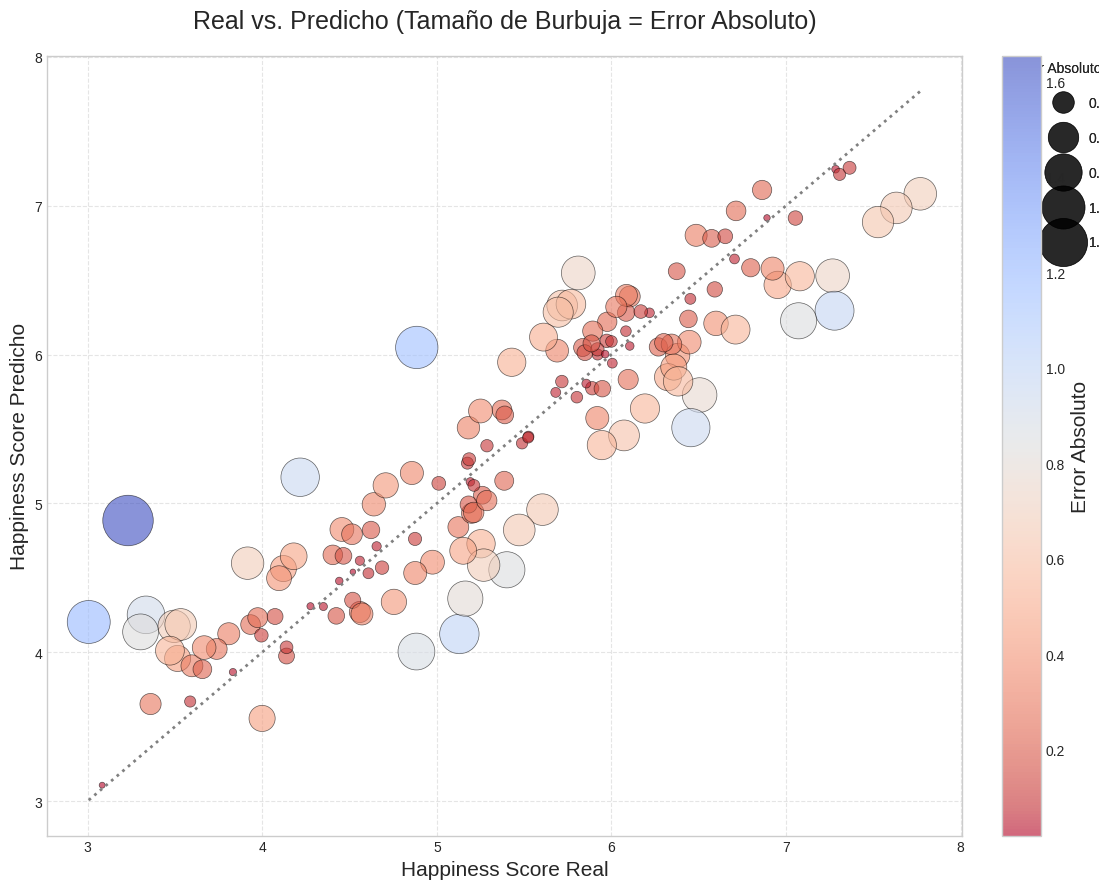

2025-05-22 15:43:12,542 - INFO - 3031806733.py:59 - Gráfico de Burbujas mostrado.


In [197]:
# Celda 19: Gráfico de Burbujas - Real vs. Predicho con Tamaño de Error

if 'df_predictions' in locals() and df_predictions is not None and not df_predictions.empty:
    # Asegurar que 'abs_error' exista (calculada en Celda 15 o aquí)
    if 'residuals' in df_predictions.columns and 'abs_error' not in df_predictions.columns:
        logging.info("Calculando la columna 'abs_error' para el gráfico de burbujas.")
        df_predictions['abs_error'] = df_predictions['residuals'].abs()
    elif 'residuals' not in df_predictions.columns and \
         'happiness_score' in df_predictions.columns and \
         'predicted_happiness_score' in df_predictions.columns:
        logging.info("Calculando 'residuals' y 'abs_error' para el gráfico de burbujas.")
        df_predictions['residuals'] = df_predictions['happiness_score'] - df_predictions['predicted_happiness_score']
        df_predictions['abs_error'] = df_predictions['residuals'].abs()
    
    if 'abs_error' in df_predictions.columns:
        logging.info("Generando Gráfico de Burbujas: Real vs. Predicho, tamaño por Error Absoluto.")
        plt.figure(figsize=(13, 9)) # Un poco más grande
        
        # Escalar el tamaño del error para que las burbujas sean visibles pero no gigantes
        # Puedes ajustar el factor de escala (ej. 1000) según tus datos
        # Aumenté el multiplicador para que las burbujas sean más notorias
        bubble_sizes = df_predictions['abs_error'] * 800  # Ajusta este multiplicador

        scatter = plt.scatter(
            df_predictions['happiness_score'], 
            df_predictions['predicted_happiness_score'], 
            s=bubble_sizes, 
            alpha=0.6, 
            c=df_predictions['abs_error'], # Colorear por error absoluto también
            cmap='coolwarm_r', # Usar _r para que errores más grandes sean más rojos (o el color "cálido")
            edgecolor='black', # Borde para mejor definición
            linewidth=0.5
        )
        
        # Línea y=x para referencia
        min_val_bubble = min(df_predictions['happiness_score'].min(), df_predictions['predicted_happiness_score'].min())
        max_val_bubble = max(df_predictions['happiness_score'].max(), df_predictions['predicted_happiness_score'].max())
        plt.plot([min_val_bubble, max_val_bubble], [min_val_bubble, max_val_bubble], color='grey', linestyle=':', lw=2, label='Predicción Perfecta (y=x)')
        
        plt.title('Real vs. Predicho (Tamaño de Burbuja = Error Absoluto)', fontsize=18, pad=20)
        plt.xlabel('Happiness Score Real', fontsize=15)
        plt.ylabel('Happiness Score Predicho', fontsize=15)
        
        # Leyenda para el tamaño de las burbujas (un poco manual)
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=5, func=lambda s: s/800) # Invertir la escala
        legend_sizes = plt.legend(handles, labels, loc="upper left", title="Error Absoluto Aprox.", 
                                  bbox_to_anchor=(1.05, 1), borderaxespad=0., labelspacing=1.5)

        plt.gca().add_artist(legend_sizes) # Añadir la leyenda de tamaños
        
        # Añadir colorbar si se usa 'c' en scatter
        cbar = plt.colorbar(scatter, label='Error Absoluto', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Error Absoluto', size=15)
        
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar para dar espacio a la leyenda y colorbar
        plt.show()
        logging.info("Gráfico de Burbujas mostrado.")
    else:
        logging.warning("Columnas necesarias ('abs_error') no disponibles para Gráfico de Burbujas.")
else:
    logging.warning("df_predictions no disponible para Gráfico de Burbujas.")